# 04. Pytorch Custom Datasets

Find a dataset, turn the dataset into numbers, build a model (or find an existing model) to find patterns in those numbers that can be used for predictions.

The dataset we're about to use has been pre-formatted for what we'd like to use it for. However, you'll often have to format your own datasets for whatever problem you're working on. This is a regular practice in the machine learning world.

![Contents](../assets/04_contents.png)

## 1. Get Data

Dataset: [Food101 dataset and paper website](https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/)


In [1]:
import requests
import zipfile
from pathlib import Path

# Setup the path to data folder
data_path = Path('data/')
image_path = data_path / "pizza_steak_shushi"

# If the image folder doesn't exist, download it and prepare it
if image_path.is_dir():
    print(f"{image_path} directory exist")
    
else:
    print(f'Did not find {image_path} directory, creating one ...')
    image_path.mkdir(parents=True, exist_ok=True)
    
    # Download the pizza, steak and shudhi data
    with open(data_path / 'pizza_steak_shushi.zip', 'wb') as f:
        requests = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
        print('Downlaoding pizza, steak, shushi data ...')
        f.write(requests.content)
        
    # unzip pizza,steak and shushi data
    with zipfile.ZipFile(data_path / 'pizza_steak_shushi.zip', 'r') as zip_ref:
        print('Unzipping pizza, steak, shushi data ...')
        zip_ref.extractall(image_path)
        

data/pizza_steak_shushi directory exist


## 2. Become one with the data (data preparation)

"If i had 8 hours to build a machine learning model, I'd spend the first 6 hours preparing my dataset"
- Abraham Lossfunction

What's inspecting the data and becoming one with it?

Before starting a project or building any kind of model, it's important to know what data you're working with.

In our case, we have images of pizza, steak and sushi in standard image classification format.

Image classification format contains separate classes of images in separate directories titled with a particular class name.

For example, all images of pizza are contained in the pizza/ directory.

This format is popular across many different image classification benchmarks, including ImageNet (of the most popular computer vision benchmark datasets).



In [2]:
import os
def walk_through_dir(dir_path):
    for dirpath, dirnames, filenames in os.walk(dir_path):
        print(f'There are {len(dirnames)} directories and {len(filenames)} in {dirpath}')
        
walk_through_dir(image_path)

There are 2 directories and 0 in data/pizza_steak_shushi
There are 3 directories and 0 in data/pizza_steak_shushi/test
There are 0 directories and 19 in data/pizza_steak_shushi/test/steak
There are 0 directories and 31 in data/pizza_steak_shushi/test/sushi
There are 0 directories and 25 in data/pizza_steak_shushi/test/pizza
There are 3 directories and 0 in data/pizza_steak_shushi/train
There are 0 directories and 75 in data/pizza_steak_shushi/train/steak
There are 0 directories and 72 in data/pizza_steak_shushi/train/sushi
There are 0 directories and 78 in data/pizza_steak_shushi/train/pizza


In [3]:
# setup train and testing paths
train_dir = image_path / 'train'
test_dir = image_path / 'test'

train_dir, test_dir

(PosixPath('data/pizza_steak_shushi/train'),
 PosixPath('data/pizza_steak_shushi/test'))

### 2.1 Visualize and Image


Let's write some code to:

- Get all of the image paths using pathlib.Path.glob() to find all of the files ending in .jpg.
- Pick a random image path using Python's random.choice().
- Get the image class name using pathlib.Path.parent.stem.
- And since we're working with images, we'll open the random image path using PIL.Image.open() (PIL stands for Python Image Library).
- We'll then show the image and print some metadata.


Random Image Path: data/pizza_steak_shushi/test/pizza/2236338.jpg
Image class: pizza
Image Height: 512
Image Width: 512


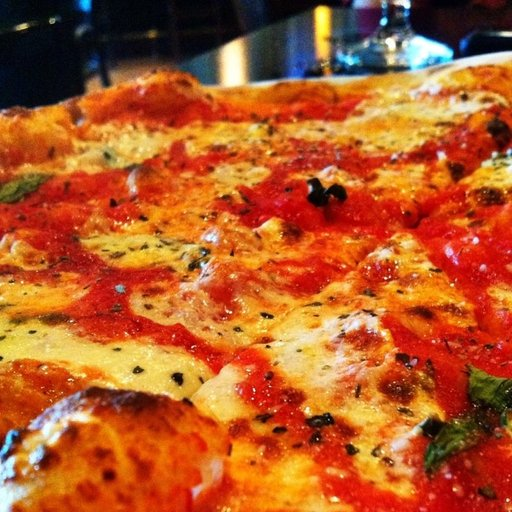

In [4]:
import random
from PIL import Image

# Set seed
random.seed(42)     # try changing this and see what happens

image_path_list = list(image_path.glob('*/*/*.jpg'))    # 1. Get all image paths (* means 'any combination')
random_image_path = random.choice(image_path_list)  # get a random image path

image_class = random_image_path.parent.stem     # get image class from path name

img = Image.open(random_image_path)     # open image

# Print metadata
print(f'Random Image Path: {random_image_path}')
print(f'Image class: {image_class}')
print(f'Image Height: {img.height}')
print(f'Image Width: {img.width}')
img

(-0.5, 511.5, 511.5, -0.5)

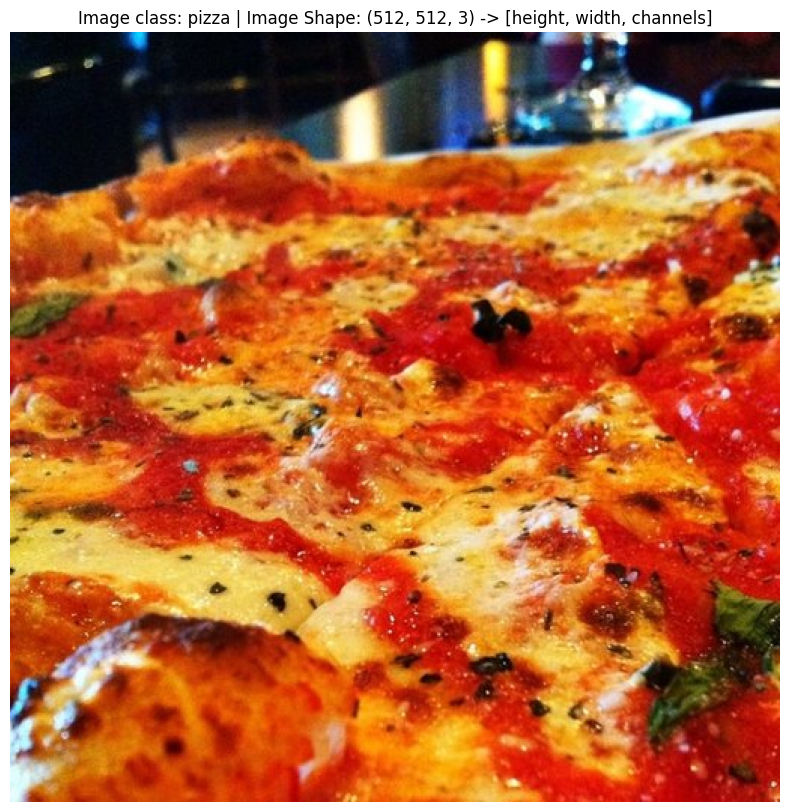

In [5]:
# We can do the same using matplotlib.pyplot.imshow(), except we have to convert the image to numpy array first

import numpy as np
import matplotlib.pyplot as plt

# Turn the image into an array
img_as_array = np.asarray(img)

plt.figure(figsize=(12,10))
plt.imshow(img_as_array)
plt.title(f'Image class: {image_class} | Image Shape: {img_as_array.shape} -> [height, width, channels]')
plt.axis('off')

## 3. Transforming Data

Before we can use our image data with PyTorch we need to:

- Turn it into tensors (numerical representations of our images).

- Turn it into a torch.utils.data.Dataset and subsequently a torch.utils.data.DataLoader, we'll call these Dataset and DataLoader for short.

Since we're working with a vision problem, we'll be looking at torchvision.datasets for our data loading functions as well as torchvision.transforms for preparing our data.


| **Problem space** | **Pre-built Datasets and Functions** |
| --- | --- |
| **Vision** | [`torchvision.datasets`](https://pytorch.org/vision/stable/datasets.html) |
| **Audio** | [`torchaudio.datasets`](https://pytorch.org/audio/stable/datasets.html) |
| **Text** | [`torchtext.datasets`](https://pytorch.org/text/stable/datasets.html) |
| **Recommendation system** | [`torchrec.datasets`](https://pytorch.org/torchrec/torchrec.datasets.html) |

In [6]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms


### 3.1 Transforming data with `torchvision.transforms`

One of the ways we can do this is by using the torchvision.transforms module.

`torchvision.transforms` contains many pre-built methods for formatting images, turning them into tensors and even manipulating them for data augmentation (the practice of altering data to make it harder for a model to learn, we'll see this later on) purposes.

To get experience with `torchvision.transforms`, let's write a series of transform steps that:

1. Resize the images using [`transforms.Resize()`](https://pytorch.org/vision/stable/generated/torchvision.transforms.Resize.html#torchvision.transforms.Resize) (from about 512x512 to 64x64, the same shape as the images on the [CNN Explainer website](https://poloclub.github.io/cnn-explainer/)).
2. Flip our images randomly on the horizontal using [`transforms.RandomHorizontalFlip()`](https://pytorch.org/vision/stable/generated/torchvision.transforms.RandomHorizontalFlip.html#torchvision.transforms.RandomHorizontalFlip) (this could be considered a form of data augmentation because it will artificially change our image data).
3. Turn our images from a PIL image to a PyTorch tensor using [`transforms.ToTensor()`](https://pytorch.org/vision/stable/generated/torchvision.transforms.ToTensor.html#torchvision.transforms.ToTensor).

We can compile all of these steps using `torchvision.transforms.Compose()`.



In [7]:
# Write transform for image
data_transform = transforms.Compose([
    transforms.Resize(size=(64,64)),     # Resize the image to 64x64
    transforms.RandomHorizontalFlip(p=0.5),     # Flip the images randomly on the horizontal
                                                # p = probability of flip, 0.5 = 50%
    transforms.ToTensor()       # turn the image into a torch.Tensor
                                # this also converts all pixel values from 0 to 255 to be between 0.0 and 1.0    
])
data_transform

Compose(
    Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
    RandomHorizontalFlip(p=0.5)
    ToTensor()
)

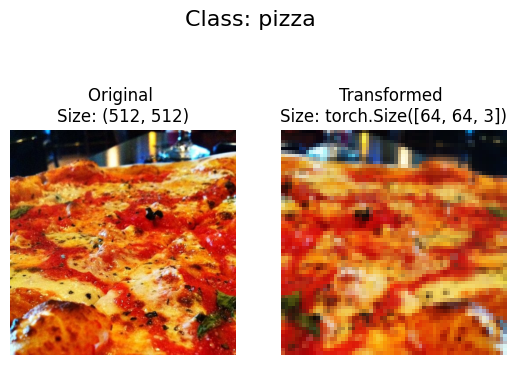

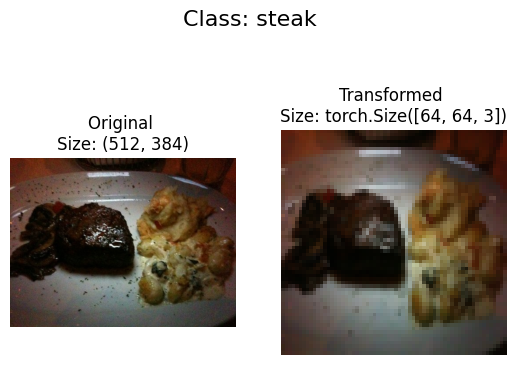

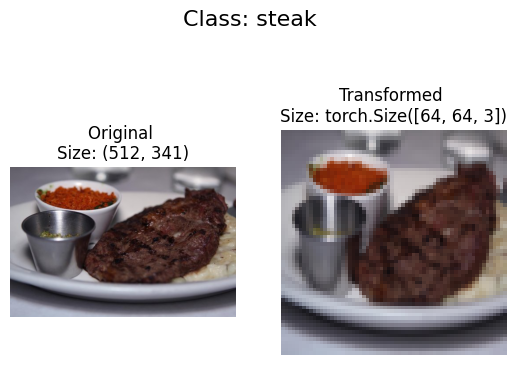

In [8]:
def plot_transformed_images(image_paths, transform, n=3, seed=42):
    """Plots a series of random images from image_paths
    
    Will open n image paths from image_paths, transform them
    with transform and plot them side by side
    
    Args:
        - image_paths (list) : List of target image paths
        - transform (PyTorch transforms) : Transforms to apply to images
        - n (int, optional) : Number of images to plot. Defaults to 3
        - seed (int, optional) : Random seed for the random generator. Defaults to 42
    """
    random.seed(seed)
    random_image_paths = random.sample(image_paths, k=n)
    for image_path in random_image_paths : 
        with Image.open(image_path) as f:
            fig, ax = plt.subplots(1,2)
            ax[0].imshow(f)
            ax[0].set_title(f'Original \nSize: {f.size}')
            ax[0].axis('off')
            
            # Transform and plot image
            # Note: permute() will change shape of image to suit matplotlib
            # Pytorch default is [C,H,W] but matplotlib is [H,W,C]
            transformed_image = transform(f).permute(1,2,0)
            ax[1].imshow(transformed_image)
            ax[1].set_title(f'Transformed \nSize: {transformed_image.shape}')
            ax[1].axis('off')
            
            fig.suptitle(f'Class: {image_path.parent.stem}', fontsize=16)
            
plot_transformed_images(image_path_list, transform=data_transform, n=3)

## 4. Option 1 : Loading Image Data Using `ImageFolder`



Alright, time to turn our image data into a Dataset capable of being used with PyTorch.

Since our data is in standard image classification format, we can use the class torchvision.datasets.ImageFolder.

Where we can pass it the file path of a target image directory as well as a series of transforms we'd like to perform on our images.

Let's test it out on our data folders train_dir and test_dir passing in transform=data_transform to turn our images into tensors.



In [9]:
# Using ImageFolder to create dataset(s)
from torchvision import datasets
train_data = datasets.ImageFolder(root = train_dir,
                                  transform = data_transform,
                                  target_transform = None)

test_data = datasets.ImageFolder(root = test_dir,
                                 transform = data_transform)

print(f"Train data: \n{train_data}\n Test Data: \n{test_data}")

Train data: 
Dataset ImageFolder
    Number of datapoints: 225
    Root location: data/pizza_steak_shushi/train
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )
 Test Data: 
Dataset ImageFolder
    Number of datapoints: 75
    Root location: data/pizza_steak_shushi/test
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )


Beautiful!

It looks like PyTorch has registered our Dataset's.

Let's inspect them by checking out the classes and class_to_idx attributes as well as the lengths of our training and test sets.



In [10]:
# Get class names as a list
class_names = train_data.classes
print(class_names)

# Can also get class names as dict
class_dict = train_data.class_to_idx
print(class_dict)

# check the lengths
len(train_data), len(test_data)

['pizza', 'steak', 'sushi']
{'pizza': 0, 'steak': 1, 'sushi': 2}


(225, 75)

We can index on our train_data and test_data Dataset's to find samples and their target labels.



In [11]:
img, label = train_data[0][0], train_data[0][1]
print(f"Image tensor: \n{img}")
print(f"Image shape: {img.shape}")
print(f"Image datatype: {img.dtype}")
print(f"Image Label: {label}")
print(f"Label Datatyoe: {type(label)}")

Image tensor: 
tensor([[[0.1137, 0.1020, 0.0980,  ..., 0.1255, 0.1216, 0.1176],
         [0.1059, 0.0980, 0.0980,  ..., 0.1294, 0.1294, 0.1294],
         [0.1020, 0.0980, 0.0941,  ..., 0.1333, 0.1333, 0.1333],
         ...,
         [0.1098, 0.1098, 0.1255,  ..., 0.1686, 0.1647, 0.1686],
         [0.0902, 0.0941, 0.1098,  ..., 0.1686, 0.1647, 0.1686],
         [0.0863, 0.0863, 0.0980,  ..., 0.1686, 0.1647, 0.1647]],

        [[0.0745, 0.0706, 0.0745,  ..., 0.0588, 0.0588, 0.0588],
         [0.0745, 0.0706, 0.0745,  ..., 0.0627, 0.0627, 0.0627],
         [0.0706, 0.0745, 0.0745,  ..., 0.0706, 0.0706, 0.0706],
         ...,
         [0.1255, 0.1333, 0.1373,  ..., 0.2510, 0.2392, 0.2392],
         [0.1098, 0.1176, 0.1255,  ..., 0.2510, 0.2392, 0.2314],
         [0.1020, 0.1059, 0.1137,  ..., 0.2431, 0.2353, 0.2275]],

        [[0.0941, 0.0902, 0.0902,  ..., 0.0157, 0.0196, 0.0196],
         [0.0902, 0.0863, 0.0902,  ..., 0.0196, 0.0157, 0.0196],
         [0.0902, 0.0902, 0.0902,  ..., 0.0

Original Shape: torch.Size([3, 64, 64]) ->[C,H,W]
Image permute shape: torch.Size([64, 64, 3]) -> [H,W,C]


Text(0.5, 1.0, 'pizza')

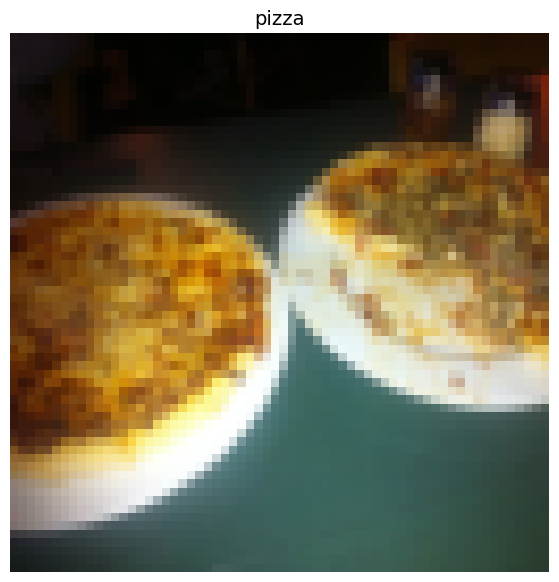

In [12]:
# Rearrange thr order of dimensions
img_permute = img.permute(1,2,0)

# Print out different shapes (before and after permute)
print(f"Original Shape: {img.shape} ->[C,H,W]")
print(f"Image permute shape: {img_permute.shape} -> [H,W,C]")

# Plot the image
plt.figure(figsize = (10,7))
plt.imshow(img.permute(1,2,0))
plt.axis('off')
plt.title(class_names[label], fontsize=14)

### 4.1 Turn Loaded images into DataLoader's

We've got our images as PyTorch Dataset's but now let's turn them into DataLoader's.

We'll do so using torch.utils.data.DataLoader.

Turning our Dataset's into DataLoader's makes them iterable so a model can go through and learn the relationships between samples and targets (features and labels).

To keep things simple, we'll use a batch_size=1 and num_workers=1.

What's num_workers?

Good question.

It defines how many subprocesses will be created to load your data.

Think of it like this, the higher value num_workers is set to, the more compute power PyTorch will use to load your data.

Personally, I usually set it to the total number of CPUs on my machine via Python's `os.cpu_count()`.

This ensures the DataLoader recruits as many cores as possible to load data.


In [13]:
# Turn train and test Datasets into DataLoaders
from torch.utils.data import DataLoader

train_dataloader = DataLoader(dataset = train_data,
                              batch_size = 1,
                              num_workers = 1,
                              shuffle = True)

test_dataloader = DataLoader(dataset = test_data,
                             batch_size = 1,
                             num_workers = 1,
                             shuffle = False)

train_dataloader, test_dataloader


(<torch.utils.data.dataloader.DataLoader at 0x3355b1720>,
 <torch.utils.data.dataloader.DataLoader at 0x335625810>)

In [14]:
img, label = next(iter(train_dataloader))

# Batch size will now be 1, try changing the batch_size parameter above and see what happens
print(f'Image shape: {img.shape} -> [B,C,H,W]')
print(f"Label Shape: {label.shape}")

Image shape: torch.Size([1, 3, 64, 64]) -> [B,C,H,W]
Label Shape: torch.Size([1])


## 5. Option 2: Loading Image Data with a Custom Dataset

The pros and cons of creating your own custom way to load `Dataset`'s?

| **Pros of creating a custom `Dataset`** | **Cons of creating a custom `Dataset`** |
| --- | --- |
| Can create a `Dataset` out of almost anything. | Even though you *could* create a `Dataset` out of almost anything, it doesn't mean it will work. |
| Not limited to PyTorch pre-built `Dataset` functions. | Using a custom `Dataset` often results in writing more code, which could be prone to errors or performance issues. |


replicating `torchvision.datasets.ImageFolder()` by subclassing `torch.utils.data.Dataset`

Write code to load your data in the format you'd like it.

In [15]:
import os
import pathlib
import torch

from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from typing import Tuple, Dict, List


In [16]:
# Instance of torchvision.datasets.ImageFolder()
train_data.classes, train_data.class_to_idx

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

### 5.1 Creating a helper function to get class names

Let's write a helper function capable of creating a list of class names and a dictionary of class names and their indexes given a directory path.

We'll :
1. Get the class names using `os.scandir()` to traverse a target directory
2. Raise an error if thr class names aren't found
3. Turn the class names into a dictionary of numerical labels, one for each class.

In [17]:
# setup path for target directory
target_directory = train_dir
print(f"Target directory: {target_directory}")

# Get the class names from the target directory
class_names_found = sorted([entry.name for entry in list(os.scandir(image_path / 'train'))])
print(f"class names found: {class_names_found}")

Target directory: data/pizza_steak_shushi/train
class names found: ['pizza', 'steak', 'sushi']


In [18]:
# Make a function to find classes in target directory
def find_classes(directory: str) -> Tuple[List[str], Dict[str, int]] :
    # Get the class names by scanning the target directory
    classes = sorted(entry.name for entry in os.scandir(directory) if entry.is_dir())
    
    # Raise an error if class names not found
    if not classes:
        raise FileNotFoundError(f"Couldn't find any classes in: {directory}")

    # Create a dictionary if index labels (computers prefer numerical than string)
    class_to_idx = {class_name:i for i,class_name in enumerate(classes)}
    
    return classes, class_to_idx

In [19]:
find_classes(train_dir)

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

### 5.2 Create a custom `Dataset` to replicate `ImageFolder`

Steps:
1. Subclass `torch.utils.data.Dataset`
2. Initialize our subclass with a `target_dir` parameter and `transform` parameter (so we have the option to transform our data if needed)
3. Create several attributes for `paths`, `transform`, `classes` and `class_to_idx`
4. Create a function to load images from file and return them, this could be using PIL or `torchvision.io` (for input/output of vision data)
5. Overwrite the `__len__` method of `torch.utils.data.Dataset` to return the number of samples in the Dataset, this is recommended but not required. This is so you can call `len(Dataset)`
6. Overwrite the `__getitem__` method of torch.utils.data.Dataset to return a single sample from Dataset, this is required

In [21]:
# Write a custom dataset class (inherits from torch.utils.data.Dataset)
from torch.utils.data import Dataset

# Subclassing torch.utils.data.Dataset
class ImageFolderCustom(Dataset):
    
    # initialize with target_dir and transform (optional parameter)
    def __init__(self, target_dir: str, transform=None) -> None:
        # create class attributes
        # get all image paths
        self.paths = list(pathlib.Path(target_dir).glob('*/*.jpg'))
        # Setup transforms
        self.transform = transform
        # create classes and class_to_idx attributes
        self.classes, self.class_to_idx = find_classes(target_dir)
        
    # make function to load images
    def load_image(self, index: int) -> Image.Image:
        image_path = self.paths[index]
        return Image.open(image_path)
    
    # overwrite the __len__() method 
    def __len__(self) -> int :
        return len(self.paths)
    
    # Overwrite the __getitem__() method (mandatory)
    def __getitem__(self, index: int) -> Tuple[torch.Tensor, int]:
        img = self.load_image(index)
        class_name = self.paths[index].parent.name
        class_idx = self.class_to_idx[class_name]
        # transform if necessary
        if self.transform:
            return self.transform(img), class_idx       # return data, label(X,y)
        else :
            return img, class_idx   # return data, label(X, y)
        
    

In [23]:
# Augment train data
train_transforms = transforms.Compose([
    transforms.Resize((64,64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

# Don't augment test data, only reshape
test_transforms = transforms.Compose([
    transforms.Resize((64,64)),
    transforms.ToTensor()
])

In [24]:
# Now comes the moment of truth
train_data_custom = ImageFolderCustom(target_dir = train_dir,
                                      transform = train_transforms)
test_data_custom = ImageFolderCustom(target_dir = test_dir,
                                     transform = test_transforms)

print(train_data_custom, "\n" , test_data_custom)

print(f"{len(train_data_custom)}, {len(test_data_custom)}")
print(f'{train_data_custom.classes}')
print(f'{train_data_custom.class_to_idx}')


225, 75
['pizza', 'steak', 'sushi']
{'pizza': 0, 'steak': 1, 'sushi': 2}


In [25]:
# check for equality amongst our custom Dataset and ImageFolder Dataset
print((len(train_data_custom) == len(train_data)))
print(train_data_custom.classes == train_data.classes)
print(train_data_custom.class_to_idx == train_data.class_to_idx)

True
True
True


### 5.3 Create a function to display random images

Steps : 
1. Take in a Dataset and a number of other parameters such as `classes`, the number of images to display and a random seed
2. To prevent the display from getting out of hand, we'll cap n at 10 images
3. Set the random seed for reproducible plots (if seed is set)
4. Get a list of random sample indexes  to plot
5. setup a matplotlib plot
6. Loop through random sample indexes found in step 4 and plot them with matplotlib
7. Make sure the sample images are of shape [H,W,C] so we can plot them

In [32]:
# take in a dataset as well as a list of class names
def display_random_images(dataset: torch.utils.data.Dataset,
                          classes: List[str] = None,
                          n: int = 10,
                          display_shape : bool = True,
                          seed: int = None) :
    # adjust display if n is too high
    if n > 10 :
        n = 10
        display_shape = False
        print(f"For display purposes, n shouldn't be larger than 10, setting to 10 and removing shape display")
    
    # set random seed
    if seed :
        random.seed(seed)
    
    # get random sample indexes
    random_samples_idx = random.sample(range(len(dataset)), k=n)
    
    # setup plot
    plt.figure(figsize=(16,8))
    
    # loop through samples and display random samples
    for i, target_sample in enumerate(random_samples_idx):
        target_image, target_label = dataset[target_sample][0], dataset[target_sample][1]
        
        # adjust image tensor shape for plotting: [C,H,W] - > [H,W,C]
        target_image_adjust = target_image.permute(1,2,0)   # [H,W,C]
        
        # Plot adjusted samples
        plt.subplot(1,n,i+1)
        plt.imshow(target_image_adjust)
        if classes :
            title = f'CLass: {classes[target_label]}'
            if display_shape:
                title = title + f'\nShape: {target_image_adjust.shape}'
        plt.title(title)

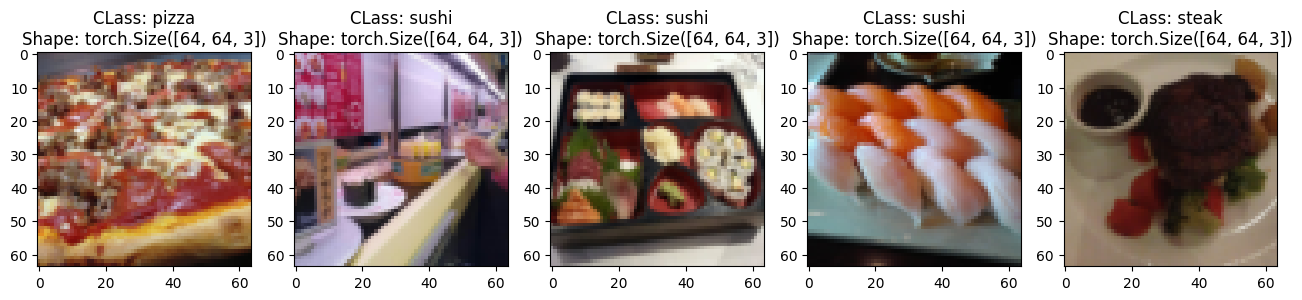

In [33]:
display_random_images(train_data, n=5, classes=class_names, seed=None)

For display purposes, n shouldn't be larger than 10, setting to 10 and removing shape display


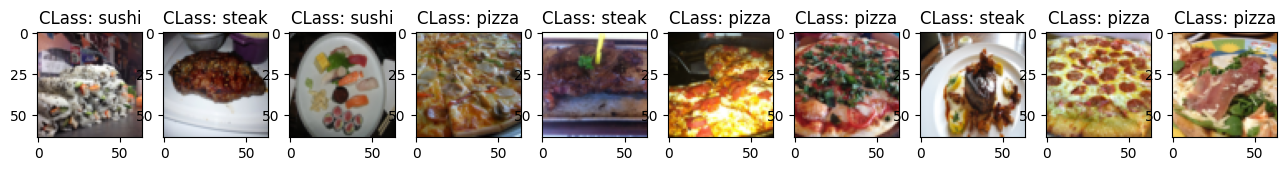

In [34]:
# display random images from ImageFolderCustom dataset
display_random_images(train_data_custom, n=12, classes=class_names, seed=None)

### 5.4 Turn custom loaded images into DataLoader's

Now we need to convert our custom `Dataset` into `DataLoader` using torch.utils.data.DataLoader


In [35]:
# turn train and test custom Dataset's into DataLoader's
from torch.utils.data import DataLoader

train_dataloader_custom  = DataLoader(dataset = train_data_custom,
                                      batch_size = 1,
                                      num_workers = 0,
                                      shuffle = True)

test_dataloader_custom = DataLoader(dataset = test_data_custom,
                                    batch_size = 1,
                                    num_workers = 0,
                                    shuffle = False)
train_dataloader_custom, test_dataloader_custom



(<torch.utils.data.dataloader.DataLoader at 0x336fb2290>,
 <torch.utils.data.dataloader.DataLoader at 0x336f4fd00>)

In [36]:
# Get image and label from custom DataLoader
img_custom, label_custom = next(iter(train_dataloader_custom))

# batch size will now be 1
print(f"Image shape: {img_custom.shape} -> [B,C,H,W]")
print(f'Label shape: {label_custom.shape}')

Image shape: torch.Size([1, 3, 64, 64]) -> [B,C,H,W]
Label shape: torch.Size([1])


## 6. Other forms of transforms (data augmentation)

[`torchvision.transforms` Documentation](https://docs.pytorch.org/vision/stable/transforms.html)

Data Augmentation is the process of altering your data in such a way that you artificially increase the diversity of your training set. 

Training a model on this artificially altered dataset hopefully results in a model that is capable of better generalization.

Machine learning is all about harnessing the power of randomness and research shows that random transforms (like [`transforms.RandAugment()`](https://pytorch.org/vision/stable/auto_examples/plot_transforms.html#randaugment) and [`transforms.TrivialAugmentWide()`](https://pytorch.org/vision/stable/auto_examples/plot_transforms.html#trivialaugmentwide)) generally perform better than hand-picked transforms.

The idea behind [TrivialAugment](https://arxiv.org/abs/2103.10158) is... well, trivial.

The PyTorch team even [used TrivialAugment it to train their latest state-of-the-art vision models](https://pytorch.org/blog/how-to-train-state-of-the-art-models-using-torchvision-latest-primitives/#break-down-of-key-accuracy-improvements).

In [37]:
from torchvision import transforms

train_transforms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.TrivialAugmentWide(num_magnitude_bins = 31),
    transforms.ToTensor()       # use ToTensor() last to get everything between 0 and 1
])

# Don't need to perform augmentation on the test data
test_transforms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor()
])

> Note: You usually don't perform data augmentation on the test set. The idea of data augmentation is to to artificially increase the diversity of the training set to better predict on the testing set.

However, you do need to make sure your test set images are transformed to tensors. We size the test images to the same size as our training images too, however, inference can be done on different size images if necessary (though this may alter performance).



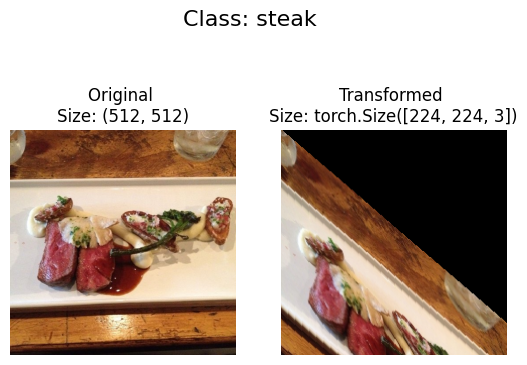

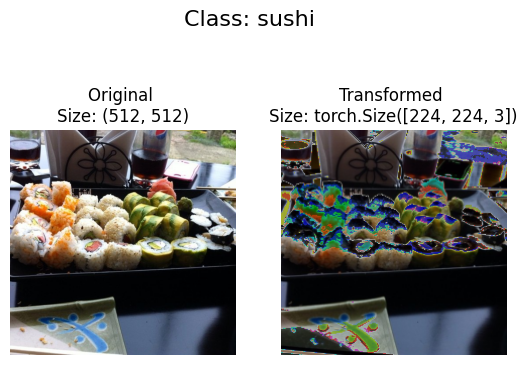

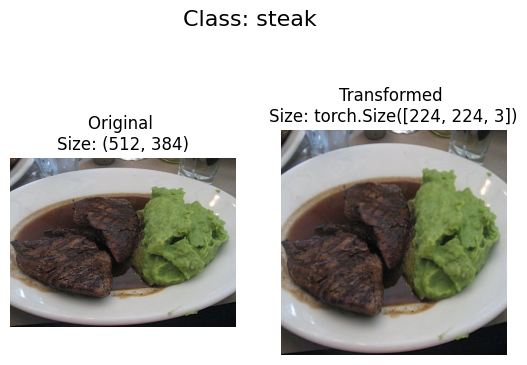

In [40]:
# Let's test our data augmentation 

# Get all image paths
image_path_list = list(image_path.glob('*/*/*.jpg'))

# Plot random images
plot_transformed_images(
    image_paths = image_path_list,
    transform = train_transforms,
    n = 3,
    seed = None
)